## In this file, I used two approaches with Chinese text


1.   To directly use the data on pretrained chinese bert model (model **output folder: output_bert_non_jieba**
2.   Other option is to use Rank or tfidf to predict the labels on same model
Output Folder: output_bert_with_jieba (sorry for name mismatch) 

*Use first model as I'm more confident with that*

Final result: 1 is the best option with 96% accuracy and better correlation, 2nd method gave 94% accuracy

Training and Testing data divided into: 70:30 ratio


If you have any trouble then please connect with me, and I want to know the mistakes which I've done (which should be a lot :) )
Please do comment

> Labels encoded: <br>

``` 
{
  0: 'politics',
  1: 'sports',
  2: 'economic',
  3: 'military',
  4: 'art',
  5: 'education',
  6: 'traffic',
  7: 'medical',
  8: 'environment',
  9: 'computer'
}
```



In [ ]:
import pandas as pd
import pandas_profiling
import seaborn as sn
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import re
import spacy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Read data from github
url = 'https://raw.githubusercontent.com/sarsiz/Hack_HacktoberFest/master/train_data.csv'
df = pd.read_csv(url)

## Exploring data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2500 non-null   int64 
 1   text        2500 non-null   object
 2   category    2500 non-null   object
dtypes: int64(1), object(2)
memory usage: 58.7+ KB


In [ ]:
list_cols = df.columns.to_list()
print(list_cols)

['Unnamed: 0', 'text', 'category']


In [ ]:
list_categories = df['category'].value_counts().index.to_list()
print(list_categories)

['politics', 'sports', 'economic', 'military', 'art', 'education', 'traffic', 'medical', 'environment', 'computer']


In [ ]:
# making sure that category column doesn't contain any special character except words
df['category'] = df['category'].apply(lambda x: re.sub(r'\W+', '', x))

### Shows the number of duplicate enteries in each category based on text

In [ ]:
df['category'][df.duplicated(subset=['text'])].reset_index(drop=True).value_counts()

computer       11
education       3
traffic         3
military        3
environment     2
medical         2
economic        2
art             2
politics        1
Name: category, dtype: int64

In [ ]:
sn.barplot(y=df['category'][df.duplicated(subset=['text'])].reset_index(drop=True).value_counts().index.values, x=df['category'][df.duplicated(subset=['text'])].reset_index(drop=True).value_counts().values, orient="h")

In [ ]:
df['category'].value_counts().index.values

array(['politics', 'sports', 'economic', 'military', 'art', 'education',
       'traffic', 'medical', 'environment', 'computer'], dtype=object)

In [ ]:
sn.barplot(y=df['category'].value_counts().index.values, x=df['category'].value_counts().values, orient="h")

### `computer` category having least number of records have maximum duplicates<br>
Data is slightly imbalanced (can also try stratified train test split)

## Preparing Train, Test set

In [ ]:
new_df = df.drop(columns=list_cols[0])  # using index as unique text ID
new_df = new_df.rename(columns={'category': 'labels'})


In [ ]:
# uncommnent below if you want to run with jieba textrank 
# new_df = exp_df.copy()

train_df_, test_df_ = train_test_split(new_df, test_size=0.30)


#### This cross-validation object is a merge of **StratifiedKFold and ShuffleSplit**, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.

Helpful where categories are not balanced

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

X, y = new_df.iloc[:,0], new_df.iloc[:,1]  # all rows 0th column and 1st column...

sss.get_n_splits(X, y)

for train_index, test_index in sss.split(X, y):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [ ]:
train_df_.head()

,text,labels
208,﻿ 日月 光华 - - Health 精华区 文章 阅读- - - - - - - ...,medical
91,﻿ 北欧 和 非洲 前线 国家 外长 会议 结束...,politics
2473,﻿ 巴解组织 正式 拒绝 美国 关于 耶路撒冷 ...,politics
1843,﻿ 日月 光华 - - FDU _ E . S . E . 精华区 文章 阅读- -...,environment
1347,﻿ 七万 张 特殊 “ 选票 ”新华社 杭州 ５...,traffic


In [ ]:
# assigning to train and test df to be input for model training
new_train_df = new_df.iloc[X_train.index]
new_test_df = new_df.iloc[X_test.index]

In [ ]:
train_df_ = new_train_df
test_df_ = new_test_df

### Model requires text, labels 
* So modify input data accordingly


In [ ]:
# rename the training and test column names based on inputs
# train_df_ = train_df_.rename(columns={'text': 'text', 'category': 'labels'})
# test_df_ = test_df_.rename(columns={'category': 'labels'})

# creating feature dict to encode labels
feature_dict = dict(zip(range(0,10),list_categories))
feature_dict

{0: 'politics',
 1: 'sports',
 2: 'economic',
 3: 'military',
 4: 'art',
 5: 'education',
 6: 'traffic',
 7: 'medical',
 8: 'environment',
 9: 'computer'}

### **Encoding Labels**

In [ ]:
# could've used scikit label encoder. Writing own encoder is also helpful 
# sometimes
def get_value(train_df_):
    list_labels = []
    for each_label in train_df_['labels'].to_list():
        list_labels.append(list_categories.index(each_label))
    return list_labels

# encoding training labels
train_df_['labels'] = get_value(train_df_)
print(train_df_.head())

# encoding testing labels
test_df_['labels'] = get_value(test_df_)
print(test_df_.head())

                                                   text  labels
933   ﻿ 【   日     期   】 19960731【   版     号   】 5【  ...       5
1210  ﻿ 【   日     期   】 19960420【   版     号   】 2【  ...       5
942   ﻿ 　 　 中国 代表团 夺金 势头 不旺新华社 曼谷 １ ２ 月 ８ 日电 （ 记者 马小...       1
459   ﻿                       上海 四月份 工业 总产值 近 百亿元新华社...       2
231   ﻿ 纠正 DIY 电脑 中 的 几个 常见 误区我 帮 很多 朋友 参谋 过 他们 的 攒机...       9
                                                   text  labels
612   ﻿                       两项 抗生素 发酵 控制系统 研制成功新华社...       7
1602  ﻿                       埃及 和 叙利亚 总统 举行会谈新华社 大马...       0
2021  ﻿美 休斯敦 举行 第十届 中文 演讲比赛- - - - - - - - - - - - -...       5
646   ﻿                       苏联政府 建议 从明年起 逐步 向 市场经济...       2
9     ﻿ 日月 光华   - -   Software 精华区 文章 阅读- - - - - - ...       9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#!pip install simpletransformers

*   Initialise Classification Model by HuggingFace, simpletransformer
*   Bert-base-chinese a pre trained model is used



In [ ]:
# if data is imbalanced, then assign custom weights to each category
total_records = new_df['labels'].value_counts().sum()
weight_im = list((new_df['labels'].value_counts()/total_records).values)
# without inputting weights model performs better

In [ ]:
# len(weight_im)

10

# Creating Model and passing arguments



*   I decided to use bert because it's multilayered Bi-directional model and on NLU related task it has achieved significant accuracy
*   LSTM is already in there, so getting advantange of it.

*   Other advantage of BERT is its Tranformer encoder reads the entire sequence of words at once, which then helps to learn the context of the word based on its surrounding words 





In [ ]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "fp16":False,
             "num_train_epochs": 6,
             "manual_seed": 12,
             "overwrite_output_dir": True,
            #  'output_dir': "/content/labelclassi"
             "output_dir": "/content/drive/My Drive/Colab Notebooks/output_bert_non_jieba",
             }

# Create a ClassificationModel
# using bert base chinese model, pretrained weights (no other model has chinese trained )
model = ClassificationModel(
    "bert", "bert-base-chinese",
    num_labels=10,
    use_cuda=True,
    args=train_args,
)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

# Training model

In [ ]:
model.train_model(train_df_)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


# Evaluate model

In [ ]:
from sklearn.metrics import f1_score, accuracy_score


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(test_df_, f1=f1_multiclass, acc=accuracy_score)

In [ ]:
result
# roughly 96% accuracy (check eval_results.txt)

# f1 score is near to 1 (good work by model)

# mcc is Mathews Correation Coefficient (helpful in case of calculating accuracy
# for imbalanced data) 
# mcc varies from (-1 to 1) Near to 1 means Predicted and True classes are well correlated
# 0 means... 50-50 chances if predicted is right or wrong


{'acc': 0.9653333333333334,
 'eval_loss': 0.21530217168904703,
 'f1': 0.9653333333333334,
 'mcc': 0.9609201351275447}

In [ ]:
test_df_.head()

,text,labels,predict
1605,"显示屏, 铰链, 时尚, 能够, 音乐, 游戏, 技术, 推荐, 掌上电脑, 别致, 拍摄,...",9,9
2195,"进行, 会见, 国际, 问题, 继续, 组织, 马利列, 主席, 议会, 主席团, 宪章, ...",0,0
1231,"北京, 集体舞, 民族舞, 文化节, 部分, 据悉, 组成, 主题, 握手, 现代舞, 献给...",1,4
2337,"教师, 学生, 机关, 教育, 学校, 有关, 教学, 影响, 会议, 教学内容, 手段, ...",5,5
1584,"手术, 导管, 医院, 国际, 引起, 心脏, 填塞, 作开, 仁济, 动脉, 肺动脉, 心...",7,7


## Making Predictions and storing raw outputs

In [ ]:
# prediction on test data
predictions, raw_outputs = model.predict(test_df_['text'].values)

In [ ]:
test_df_['predict'] = predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# converting categories to their original labels using feature_dict


In [ ]:
list_label = []
list_pred = []
for lab in list(zip(test_df_[['labels', 'predict']].values)):
  labe,pred = lab[0]
  list_label.append(feature_dict.get(labe))
  list_pred.append(feature_dict.get(pred))

new_dd = test_df_.copy()
new_dd['label_t'] = list_label
new_dd['label_pred'] = list_pred

print(new_dd[['label_t', 'label_pred']])

        label_t label_pred
612     medical    medical
1602   politics   politics
2021  education        art
646    economic   economic
9      computer   computer
...         ...        ...
109         art        art
1120   politics   politics
2393     sports     sports
1201   politics   politics
1521   politics   politics

[750 rows x 2 columns]


# this will show mis_predicted categories


In [ ]:
mis_predicted_text = []
for each_row in new_dd[['label_t', 'label_pred']].values:
  if len(set(each_row)) > 1:
    mis_predicted_text.append(each_row)
    
pd.DataFrame(mis_predicted_text, columns=['true', 'predict']).describe()
print(pd.DataFrame(mis_predicted_text, columns=['true', 'predict']))

           true      predict
0     education          art
1     education     military
2      military     politics
3     education     military
4      economic          art
5        sports     politics
6        sports          art
7           art    education
8   environment     military
9           art    education
10     economic      traffic
11     military     politics
12     military     politics
13     politics     economic
14       sports      traffic
15     politics     military
16     politics     military
17     military     politics
18     computer  environment
19    education     military
20     politics     military
21     military     politics
22     economic     politics
23     economic     politics
24     economic    education
25     politics     economic


In [ ]:
# plot confusion matrix
cm = confusion_matrix(test_df_['labels'], test_df_['predict'])
cm

array([[129,   0,   2,   3,   0,   0,   0,   0,   0,   0],
       [  1, 117,   0,   0,   1,   0,   1,   0,   0,   0],
       [  2,   0,  82,   0,   1,   1,   1,   0,   0,   0],
       [  5,   0,   0,  61,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  64,   2,   0,   0,   0,   0],
       [  0,   0,   0,   3,   1,  55,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  57,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  54,   0,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,  53,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,  52]])

In [ ]:
cm_df = (pd.DataFrame(cm, index=list_categories, columns=list_categories))
cm_df

,politics,sports,economic,military,art,education,traffic,medical,environment,computer
politics,129,0,2,3,0,0,0,0,0,0
sports,1,117,0,0,1,0,1,0,0,0
economic,2,0,82,0,1,1,1,0,0,0
military,5,0,0,61,0,0,0,0,0,0
art,0,0,0,0,64,2,0,0,0,0
education,0,0,0,3,1,55,0,0,0,0
traffic,0,0,0,0,0,0,57,0,0,0
medical,0,0,0,0,0,0,0,54,0,0
environment,0,0,0,1,0,0,0,0,53,0
computer,0,0,0,0,0,0,0,0,1,52


In [ ]:
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm_df, annot=True, annot_kws={"size": 16}) # font size

plt.show()

# Load the Model

In [ ]:
s# to load model
model = ClassificationModel(model_name, model_path, num_labels=no_labels) # model name: bert

# Trying approach #2 
Not much helpful

In [ ]:
import jieba
import tqdm
from joblib import Parallel, delayed
import re

In [ ]:
import jieba.analyse

In [ ]:
exp_df = new_df.copy()
exp_df.head()

,text,labels
0,"公路, 主管部门, 养护, 不得, 应当, 修建, 规定, 设施, 国家, 规划, 专用, ...",traffic
1,"日本, 大量, 资产额, 历史纪录, 表明, 纪录, 部门, 在外, 东京, 报告书, 历史...",economic
2,"画展, 家乡, 革命, 举办, 画家, 教育, 参观, 家乡父老, 事业, 中国画, 艺术,...",art
3,"降价, 市场, 消费者, 企业, 价格, 发现, 生产, 记者, 商品价格, 冰箱, 商品,...",economic
4,"叙利亚, 巴解, 巴勒斯坦, 以色列, 问题, 双方, 有关, 总统, 首脑会议, 阿盟, ...",politics


In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = " ".join(word for word in text.split())



# new_df['text'] = new_df['text'].apply(clean_text)

# use withWeight True to get tfidf... Jieba is new and cool
for i in range(0,len(new_df['text'])):
    list_topk = jieba.analyse.textrank(new_df['text'].iloc[i], topK=20, withWeight=False, allowPOS=('ns', 'n', 'vn', 'v'))
    string = ", ".join(list_topk)
    exp_df['text'].iloc[i] = string


# from heere


# def jieba_cut(x, sep=' '):
#     return sep.join(jieba.cut(x, cut_all=False))

# print('raw', new_df['text'][0])
# print('cut', jieba_cut(new_df['text'][0], ','))

## from here go back to first comment and run again..also uncomment exp_df 

# Experimenting and Visualizing text data

In [ ]:
new_df['text_cut'] = Parallel(n_jobs=4)(
    delayed(jieba_cut)(x) for x in tqdm.notebook.tqdm(new_df['text'].values)
)

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator


import matplotlib.font_manager as fm
# need to download and add this to the path 
# url = 'https://github.com/tkiapril/source-fonts/blob/master/SourceHanSansCN-Regular.otf'
font_path = '/content/SourceHanSansCN-Regular.otf'
prop = fm.FontProperties(fname=font_path)


def get_wc(
    text_li, 
    background_color='white',
    font_path=font_path,
    width=640,
    height=480,
    max_font_size=64,
    mask=None,
    margin=1,
):
    return WordCloud(
        background_color=background_color,
        font_path=font_path,
        width=width,
        height=height,
        max_font_size=max_font_size,
        mask=mask,
        margin=margin,
    ).generate(" ".join(text_li))

# Word Cloud shows quite many different words in the text... not much repetitions

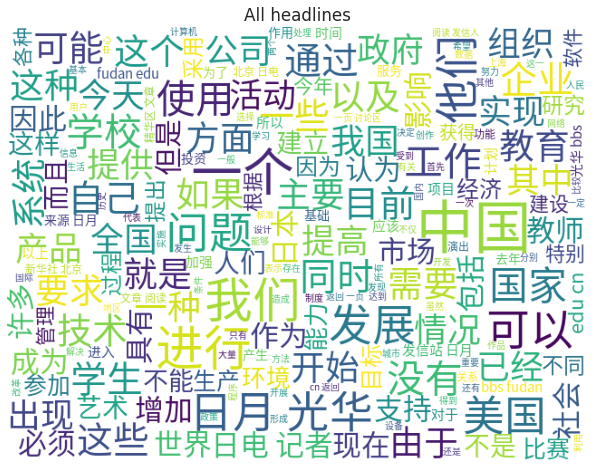

In [ ]:
text_li = new_df['text_cut'].values.tolist()
wc = get_wc(text_li)
plt.figure(figsize=[12, 8])
plt.imshow(wc)
plt.title('All headlines')
plt.axis('off');

In [ ]:
new_df['text_cut'].values.tolist()

In [ ]:
new_df['text_cut'].iloc[0]

'\ufeff   日月   光华       -   -       Traffic   _   Info   精华区   文章   阅读 -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   - 发信人   :       RaoRen       (   亮马   ？   亮马   ！   )   ,       信   区   :       Traffic   _   Info 标           题   :       中华人民共和国   公路   管理条例 发信站   :       日月   光华       (   2002   年   09   月   10   日   17   :   58   :   59       星期二   )   ,       站   内   信件 中华人民共和国   公路   管理条例 栏目   类型   ：   综合性   法规       加入   时间   ：   2001   年   12   月   1   日   14   :   0 中华人民共和国   公路   管理条例 （   １   ９   ８   ７   年   １   ０   月   １   ３   日   国务院   发布   ） 第一章       总则 第一条       为   加强   公路   的   建设   和   管理   ，   发挥   公路   在   国民经济   、   国防   和   人民   生活   中   的   作用 ，   适应   社会主义   现代化   建设   的   需要   ，   特   制定   本   条例  

In [ ]:
# !pip install -U spacy

In [ ]:
# !python -m spacy download zh_core_web_sm

In [ ]:
!python -m spacy download zh_core_web_lg

     |████████████████████████████████| 603.9MB 69.5MB/s 
  Created wheel for zh-core-web-lg: filename=zh_core_web_lg-2.3.1-cp36-none-any.whl size=603703219 sha256=ce23fd5d78be0772753a8f336f370babfd636e3276bd12a79593c22b1ea5081b
  Stored in directory: /tmp/pip-ephem-wheel-cache-wjzkdulj/wheels/bb/4b/a6/1803f0dc5d10fecba2e75f297662809791973ab11c934c5254
Successfully built zh-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('zh_core_web_lg')


In [ ]:
nlp = spacy.load("zh_core_web_sm")

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.620 seconds.
Prefix dict has been built successfully.


In [ ]:
doc = nlp(new_df['text'].iloc[0])

In [ ]:
for token in doc:
  print(token.text)

In [ ]:
# THis is better than jieba in terms of usage... Will explore this weekend or after office hours :)

In [ ]:
# Thank you for this new challenge...(we in general convert chinese 
# or non-english text to English using translation) and then build model on top